<a href="https://colab.research.google.com/github/gceltbdc/Plant-Disease-Detection/blob/main/Project_Plant_Disease_Detection_CNN_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Seeding for reproducibility


In [ ]:
# Set seeds for reproducibility
import random
random.seed(0)  # Sets seed for basic random ops

import numpy as np
np.random.seed(0) # Used in data generation, shuffling

import tensorflow as tf
tf.random.set_seed(0)   # Affects weight initialization, dropout, etc.

Importing the dependencies

In [ ]:
import os
import json
from zipfile import ZipFile
from PIL import Image   # Python Imaging library (PIL)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,models       # to build CNN architecture

numpy: Handles numerical operations, like arrays.

matplotlib.pyplot: Helps in plotting images or graphs.

os: Lets you interact with your files/folders on disk.

cv2: From OpenCV, helps in image reading and processing.

random: Used to shuffle or pick random items.

keras.models.Sequential: A way to build a neural network layer by layer.

keras.layers: Used to add CNN layers like convolution, pooling, etc.

to_categorical: Converts labels like 0, 1, 2 into one-hot encoded vectors.

Data Curation


In [ ]:
!pip install kaggle

In [ ]:
kaggle_credentials = json.load(open('/content/kaggle (3).json'))

In [ ]:
# setup kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

In [ ]:
!rm -f plantvillage-dataset.zip           # deletes older .zip files and then installs new zip file
!kaggle datasets download -d abdallahalidev/plantvillage-dataset --force


Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 96% 1.96G/2.04G [00:12<00:00, 137MB/s]
100% 2.04G/2.04G [00:12<00:00, 176MB/s]


In [ ]:
!ls

'kaggle (3).json'   plantvillage-dataset.zip   sample_data


In [ ]:
# Unzip the downloaded dataset
with ZipFile('plantvillage-dataset.zip', 'r') as zip_ref:
   zip_ref.extractall()

In [ ]:
print(os.listdir('plantvillage dataset/'))


print(len(os.listdir('plantvillage dataset/segmented')))
print(os.listdir('plantvillage dataset/segmented')[:5])  # first 5 segmented folders of images

print(len(os.listdir('plantvillage dataset/color')))
print(os.listdir('plantvillage dataset/color')[:5])

print(len(os.listdir('plantvillage dataset/grayscale')))
print(os.listdir('plantvillage dataset/grayscale')[:5])

['grayscale', 'segmented', 'color']
38
['Potato___Early_blight', 'Grape___Esca_(Black_Measles)', 'Tomato___Leaf_Mold', 'Potato___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)']
38
['Potato___Early_blight', 'Grape___Esca_(Black_Measles)', 'Tomato___Leaf_Mold', 'Potato___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)']
38
['Potato___Early_blight', 'Grape___Esca_(Black_Measles)', 'Tomato___Leaf_Mold', 'Potato___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)']


Number of Classes = 38

In [ ]:
print(len(os.listdir('/content/plantvillage dataset/color/Grape___healthy')))
print(os.listdir('/content/plantvillage dataset/color/Grape___healthy')[:5])


423
['4a31039d-54b1-4a0f-bc5f-2032f94c27af___Mt.N.V_HL 9040.JPG', 'e53defea-84c4-4b41-8c12-a53dda9e61b8___Mt.N.V_HL 9085.JPG', 'd9399e07-dc4e-4c86-af6d-a74a4bccc089___Mt.N.V_HL 8984.JPG', 'b53106de-9795-4c49-ab42-6aac4ff9c886___Mt.N.V_HL 6157.JPG', '17572261-c800-42b7-8baf-2f73f7657578___Mt.N.V_HL 9009.JPG']


Data Processing

In [ ]:
# Dataset Path
base_dir = '/content/plantvillage dataset/color'

(256, 256, 3)


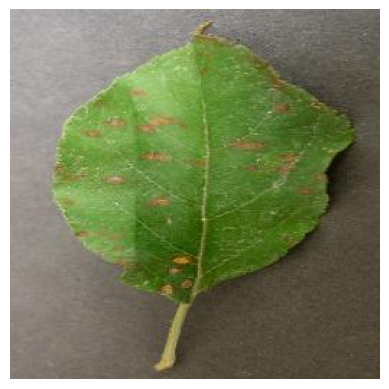

In [ ]:
image_path = '/content/plantvillage dataset/color/Apple___Cedar_apple_rust/025b2b9a-0ec4-4132-96ac-7f2832d0db4a___FREC_C.Rust 3655.JPG'

# Read the image
img = mpimg.imread(image_path)

print(img.shape)    #(height, width, RGB)
# Plot the image
plt.imshow(img)
plt.axis('off')  #It turns off the display of all axis-related components. This includes the x and y axis lines, tick marks, tick labels, and the grid.
plt.show()

In [ ]:
# Image Parameters
img_size = 224
batch_size = 32  #the number of training examples used in one iteration or update of the model's parameters during training

Train Test Split

In [ ]:
# image Data Generators
data_gen = ImageDataGenerator(
    rescale=1/255,   # used to scale pixel values before feeding them into a neural network, it multiplies the pixel values of the images by a given factor.
    validation_split = 0.2  # Use 20% of data for validation
    )

In [ ]:
# Train Generator
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training', # Use training subset
    class_mode = 'categorical'
)

Found 43456 images belonging to 38 classes.


In [ ]:
# Validation Generator
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',  # Use testing subset
    class_mode = 'categorical'
)


Found 10849 images belonging to 38 classes.


Convolutional Neural Network

In [ ]:
# Model Definition
model = models.Sequential() # It means layers will be added one after another in a straight line.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3))) #Detects basic features like edges, colors, corners from the image.
model.add(layers.MaxPooling2D((2, 2))) # It reduces the image size by half (downsampling) while keeping important features.

model.add(layers.Conv2D(64, (3, 3), activation='relu')) # Learns more complex features like disease spots or vein patterns.
model.add(layers.MaxPooling2D((2, 2))) # Again reduces size by half and extracts dominant patterns.

model.add(layers.Flatten()) # Flattens the output of the previous layer into a 1D vector.
model.add(layers.Dense(256, activation='relu')) # Helps in learning decision rules for classification; 256 neurons
model.add(layers.Dense(train_generator.num_classes, activation='softmax')) # Output Layer -> Number of neurons = number of classes (e.g., 2 for Healthy/Diseased),

 # softmax activation: turns outputs into probabilities for each class.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


*Rectified Linear Unit (ReLU) represented mathematically as f(x) = max(0, x)*

This model works as:

Convolutions → detect patterns in the image,

Pooling → reduce size and highlight important parts,

Flatten + Dense → learn which patterns mean which disease,

Softmax → gives final prediction.

Total Parameters: 47,805,158 → Number of weights the model can learn.

Trainable Parameters: All 47.8 million are trainable.

Non-trainable Parameters: 0 → No frozen layers.



In [ ]:
# model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    47,776,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,805,158 (182.36 MB)

 Trainable params: 47,805,158 (182.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the Model
model.compile(optimizer='adam',  # Optimization algorithm that adjusts weights.
              loss='categorical_crossentropy', # Loss function for multi-class classification
              metrics=['accuracy']) # You want to monitor accuracy during training.

Model Training



In [ ]:
# Training the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size, # Number of steps per epoch
    epochs=5, # Number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size # Number of validation steps
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 101s 70ms/step - accuracy: 0.6002 - loss: 1.6296 - val_accuracy: 0.8724 - val_loss: 0.4131
Epoch 2/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 134s 67ms/step - accuracy: 0.9206 - loss: 0.2502 - val_accuracy: 0.8666 - val_loss: 0.4273
Epoch 3/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 92s 68ms/step - accuracy: 0.9638 - loss: 0.1136 - val_accuracy: 0.8895 - val_loss: 0.4233
Epoch 4/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 144s 106ms/step - accuracy: 0.9800 - loss: 0.0606 - val_accuracy: 0.8838 - val_loss: 0.4891
Epoch 5/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 199s 104ms/step - accuracy: 0.9839 - loss: 0.0517 - val_accuracy: 0.8683 - val_loss: 0.6299


Model Evaluation

In [ ]:
# Model Evaluation
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


Evaluating model...
339/339 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.8685 - loss: 0.6313
Validation Accuracy: 86.84%


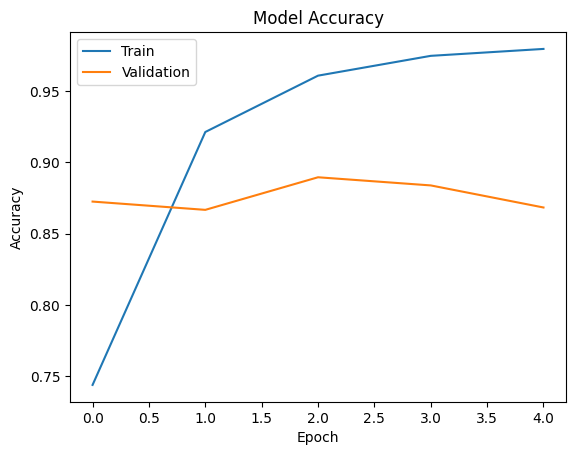

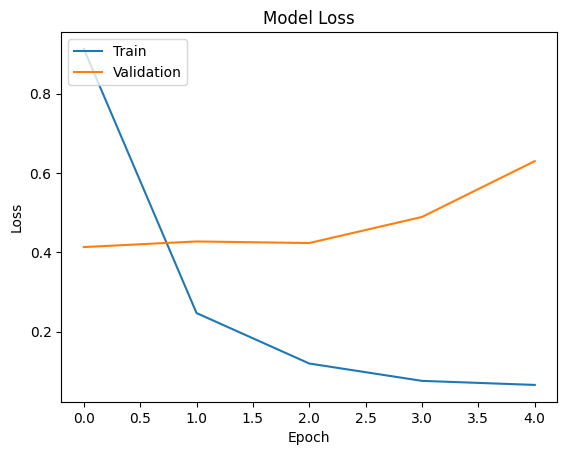

In [ ]:
# Plot training & Validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Building a Predictive System

In [ ]:
# Function to load and Preprocess the Image using Pillow
def load_and_preprocess_image(image_path, target_size=(224,224)):
  # Load the image
    img = Image.open(image_path)
  # Resize the image
    img = img.resize(target_size)
  # Convert the image to a numpy array
    img_array = np.array(img)
  # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
  # Scale the image values to [0,1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
   preprocessed_img = load_and_preprocess_image(image_path)
   predictions = model.predict(preprocessed_img)
   predicted_class_index = np.argmax(predictions, axis=1)[0]
   predicted_class_name = class_indices[predicted_class_index]
   return predicted_class_name

In [ ]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

In [ ]:
class_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [ ]:
# Saving the class name as json file
json.dump(class_indices, open('class_indices.json', 'w'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━

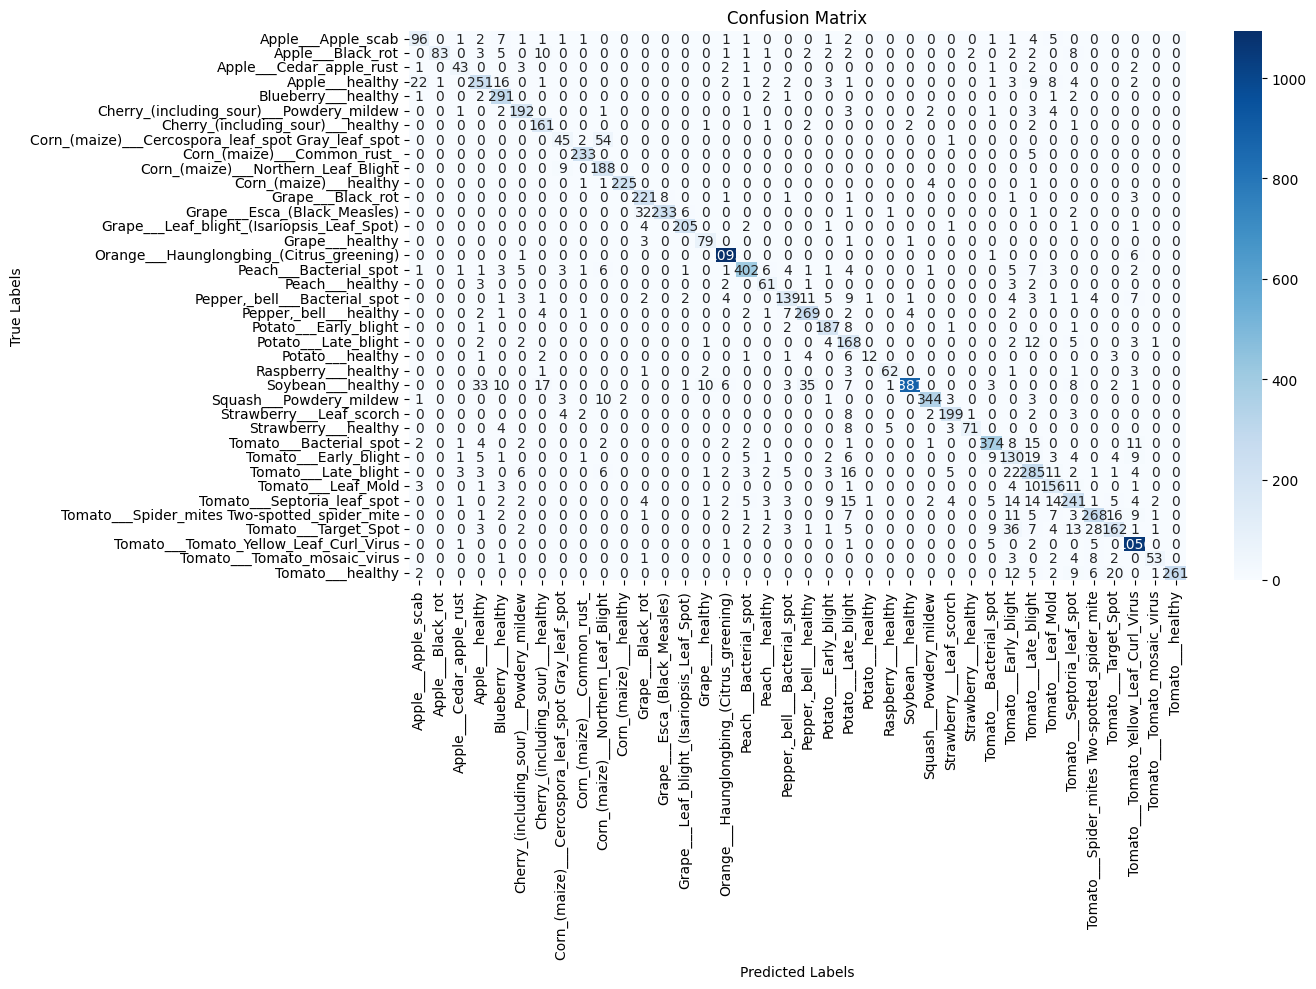

Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.74      0.76      0.75       126
                                 Apple___Black_rot       0.99      0.67      0.80       124
                          Apple___Cedar_apple_rust       0.81      0.78      0.80        55
                                   Apple___healthy       0.79      0.76      0.78       329
                               Blueberry___healthy       0.83      0.97      0.90       300
          Cherry_(including_sour)___Powdery_mildew       0.88      0.91      0.90       210
                 Cherry_(including_sour)___healthy       0.81      0.95      0.88       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.69      0.44      0.54       102
                       Corn_(maize)___Common_rust_       0.96      0.98      0.97       238
               Corn_(maize)___Northern_Leaf_Blight     

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix # Tools to evaluate model performance.
import seaborn as sns # Used for making nice-looking plots (especially heatmaps).



# Get true and predicted labels
Y_true = []
Y_pred = []

# Get predictions for entire validation set
for i in range(len(validation_generator)):
    x_val, y_val = validation_generator[i]  # x_val -> images, y_val -> true labels
    preds = model.predict(x_val)            # Predicts outputs
    Y_true.extend(np.argmax(y_val, axis=1)) # Converts one-hot format (e.g., [0, 1]) to class index (e.g., 1).
    Y_pred.extend(np.argmax(preds, axis=1)) # Y_true holds actual labels, Y_pred holds predicted labels.

# Class labels
class_labels = list(train_generator.class_indices.keys()) # Gets actual class names (like Healthy, Diseased) in order of class indices

# Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred)  # matrix in which rows = actual classes, columns = predicted classes
                                       # Each cell shows how many times a true class was predicted as another class.

# Plot Confusion Matrix
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Draws a heatmap (colored grid) of the confusion matrix.

# annot=True: Shows numbers inside the boxes.

# xticklabels/yticklabels: Adds class names to axes.

# Helps you visually understand :-

# 1. Where predictions are correct (diagonal cells),

# 2. Where the model makes mistakes (off-diagonal cells).



# Classification Report
report = classification_report(Y_true, Y_pred, target_names=class_labels)
print("Classification Report:\n")
print(report)

# Precision: How many predicted "Diseased" were really diseased?

# Recall: How many actual diseased were correctly predicted?

# F1-score: Harmonic Mean of precision and recall (1 -> Perfect score, 0 -> Worst score).

# Support: How many test samples were in each class.

In [ ]:
model.save('drive/MyDrive/Project_Final/Project_Plant_Disease_Detection_CNN_DL.h5')

In [ ]:
model.save('Project_Plant_Disease_Detection_CNN_DL.h5')